<h1 style="text-align: center; color: red">Projet : Exploration de donnée et prédiction</h1>

<h2 style="color: green">GROUPE 1 :</h2>
<ul>
    <li>DERRUDER Thomas</li>
    <li>BARREZ Lucas</li>
    <li>MOREL Alexandre</li>
</ul>

<p>Dans le cadre de ce projet d'exploration et de prédiction, nous avons décidé de travailler sur le projet d'analyse des prix de logement Airbnb. L'objectif est de comprendre l'influence de l'ensemble des caractéristiques d'un logement sur son prix, et finalement d'être capable de prédire le prix d'une location d'un logement donné.</p>

<h2 style="color: green">Initialisation du projet :</h2>

<h3>Installation et importation des librairies :</h3>


In [1]:
%pip install pandas
%pip install numpy
%pip install seaborn
%pip install scikit-learn
%pip install folium

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.9.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.2.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached matplotlib-3.9.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
Using cached contourpy-1.2.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (309 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 850.5 kB/s eta 0:00:0031m4.7 MB/s eta 0:00:01
  Using cached joblib-1.4.2-py3-none-any.whl.metada

In [4]:
# import csv in pandas airbnb test and train data
import logging
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

import folium
from folium.plugins import HeatMap

<h3>Exécution en ligne du projet</h3>
<p>L'ensemble de se notebook est exécutable sur le cloud en cas de manque de ressource sur votre appareil local.</p>


<h2 style="color: green">Exploration des données :</h2>

<p>Explorons les données afin d'en apprendre davantage sur la structure du dataset. Dans cette partie nous traiterons également du nettoyage du dataset.</p>


In [18]:
# Chargement des données dans un DataFrame
data = pd.read_csv("./data/airbnb_train.csv")
data_test = pd.read_csv("./data/airbnb_test.csv")

Caractéristiques du dataset :


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22234 entries, 0 to 22233
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      22234 non-null  int64  
 1   log_price               22234 non-null  float64
 2   property_type           22234 non-null  object 
 3   room_type               22234 non-null  object 
 4   amenities               22234 non-null  object 
 5   accommodates            22234 non-null  int64  
 6   bathrooms               22183 non-null  float64
 7   bed_type                22234 non-null  object 
 8   cancellation_policy     22234 non-null  object 
 9   cleaning_fee            22234 non-null  bool   
 10  city                    22234 non-null  object 
 11  description             22234 non-null  object 
 12  first_review            17509 non-null  object 
 13  host_has_profile_pic    22178 non-null  object 
 14  host_identity_verified  22178 non-null

In [7]:
data.shape
print(f"Nombre de lignes : {data.shape[0]} \nNombre de colonnes : {data.shape[1]}")

Nombre de lignes : 22234 
Nombre de colonnes : 28


In [90]:
# Valeurs manquantes dans le jeu de données
data.isnull().sum()

id                        0   
log_price                 0   
property_type             0   
room_type                 0   
amenities                 0   
accommodates              0   
bathrooms                 51  
bed_type                  0   
cancellation_policy       0   
cleaning_fee              0   
city                      0   
description               0   
first_review              4725
host_has_profile_pic      56  
host_identity_verified    56  
host_response_rate        5475
host_since                56  
instant_bookable          0   
last_review               4716
latitude                  0   
longitude                 0   
name                      0   
neighbourhood             2086
number_of_reviews         0   
review_scores_rating      4978
zipcode                   303 
bedrooms                  26  
beds                      35  
dtype: int64

Afin de prendre une décision sur la suppression de certaines lignes, regardons la quantité de valeurs nulles relativement au dataset :


In [91]:
# Calcul du pourcentage de valeurs manquantes pour chaque colonne
missing_percent = (data.isnull().sum() / len(data)) * 100

# Affichage des colonnes avec des valeurs manquantes
missing_percent[missing_percent > 0]

bathrooms                 0.229378 
first_review              21.251237
host_has_profile_pic      0.251867 
host_identity_verified    0.251867 
host_response_rate        24.624449
host_since                0.251867 
last_review               21.210758
neighbourhood             9.382028 
review_scores_rating      22.389134
zipcode                   1.362778 
bedrooms                  0.116938 
beds                      0.157417 
dtype: float64

Plus que de supprimer aveuglément les cases manquantes, menons une étude un peu plus approfondie des données à disposition...

### Représentation globale des données

Afin de prendre des décisions sur quelles colonnes nous allons écarter de notre analyse, et sur la manière dont nous allons compléter les valeurs non définies, observons chacune des features de manières plus approfondies. 

De plus, la matrice de corrélation (incluant uniquement les valeurs numériques) pourra nous être utile lorsque nous souhaiterons rassembler des données les unes avec les autres.

<Axes: >

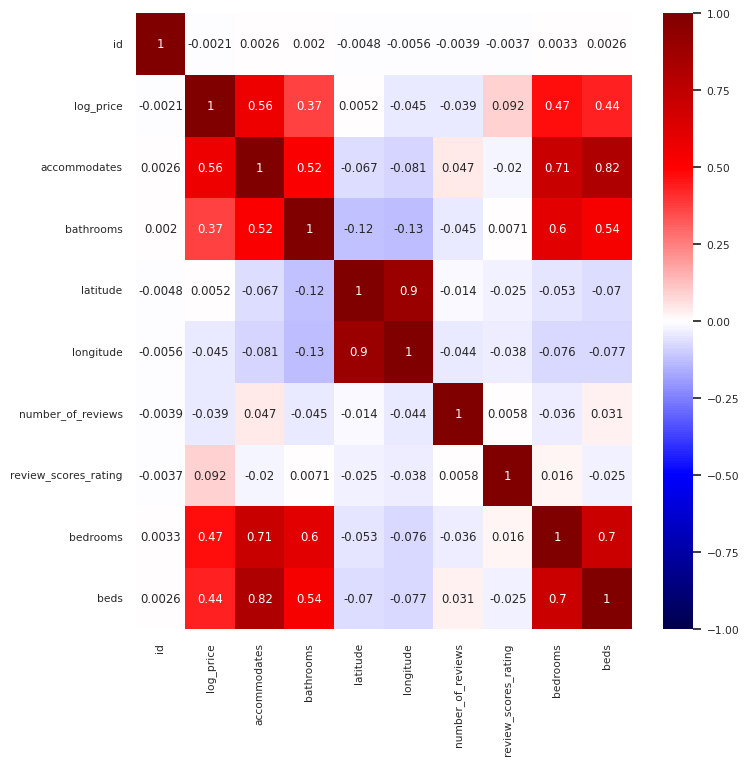

In [8]:
numeric_data = data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()

sns.set(font_scale=0.7)
plt.figure(figsize=(8,8))
sns.heatmap(correlation_matrix, cmap="seismic", annot=True, vmin=-1, vmax=1)

De prime abord, nous remarquons les corrélations suivantes :

- Evidemment la latitude et la longitude sont très corrélées.
- Le nombre de lits, le nombre de chambres, le nombre de pièces sont fortement corrélés.
- Le nombre de salle de bain et le nombre de pièces sont eux aussi très corrélés.
De manière générale, les caractéristoques citées précédemment sont fortement corrélés au prix de la location.

### Quant est-il des caractéristiques non chiffrées ?

In [9]:
pd.set_option('display.max_colwidth', 0)
data[['property_type','room_type','bed_type','cancellation_policy',
      'cleaning_fee','city','host_has_profile_pic','host_identity_verified',
     'host_response_rate','instant_bookable','neighbourhood']].agg(['unique']).transpose()

,unique
property_type,"[House, Apartment, Townhouse, Guest suite, Condominium, Timeshare, Chalet, Guesthouse, Bungalow, Loft, In-law, Boat, Dorm, Other, Bed & Breakfast, Camper/RV, Villa, Boutique hotel, Cabin, Hostel, Hut, Yurt, Serviced apartment, Castle, Vacation home, Tent, Cave, Tipi, Earth House, Island, Treehouse]"
room_type,"[Private room, Entire home/apt, Shared room]"
bed_type,"[Real Bed, Pull-out Sofa, Futon, Airbed, Couch]"
cancellation_policy,"[flexible, strict, moderate, super_strict_30, super_strict_60]"
cleaning_fee,"[False, True]"
city,"[LA, NYC, DC, SF, Chicago, Boston]"
host_has_profile_pic,"[t, nan, f]"
host_identity_verified,"[f, t, nan]"
host_response_rate,"[nan, 100%, 80%, 86%, 90%, 89%, 40%, 81%, 70%, 99%, 0%, 20%, 67%, 56%, 43%, 75%, 94%, 88%, 95%, 60%, 83%, 78%, 96%, 50%, 87%, 97%, 91%, 79%, 98%, 63%, 71%, 93%, 92%, 64%, 42%, 82%, 25%, 33%, 54%, 73%, 57%, 58%, 17%, 30%, 85%, 53%, 44%, 31%, 77%, 29%, 84%, 69%, 68%, 38%, 35%, 52%, 76%, 72%, 14%, 65%, 55%, 74%, 62%, 21%, 47%, 61%, 13%, 46%, 66%, 10%, 26%]"
instant_bookable,"[t, f]"


On remarque d'ores et déjà que les colonnes "instant_bookable", "host_identity_verified", "host_has_profile_pic", "cleaning_fee" doivent bien être de type Boolean.

In [12]:
def countplot_generator(data, column_name, title, x_label, y_label, ax=None, y_sticker=None):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    if ax is None:
        plt.figure(figsize=(12, 8))
        ax = plt.gca()
    else:
        ax.set_facecolor(".9")

    stickers = y_sticker if y_sticker else data[column_name].value_counts().index

    plot = sns.countplot(y=column_name, data=data, order=stickers, hue=column_name, dodge=False, legend=False, ax=ax)

    ax.set_title(title, fontsize=22, weight='bold', color='darkblue', pad=20)
    ax.set_xlabel(x_label, fontsize=16, weight='bold', color='darkblue')
    ax.set_ylabel(y_label, fontsize=16, weight='bold', color='darkblue')

    for p in plot.patches:
        width = p.get_width()
        ax.text(width + 600, p.get_y() + p.get_height() / 2, '{:1.0f}'.format(width), ha='center', va='center', fontsize=12, color='black', weight='bold')


def piechart_generator(data, column_name, threshold=0.01, title='Répartition des catégories', ax=None):
    counts = data[column_name].value_counts()
    percentages = counts / counts.sum()

    large_categories = percentages[percentages >= threshold]
    small_categories = percentages[percentages < threshold]

    if not small_categories.empty:
        large_categories['Others'] = small_categories.sum()

    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()

    ax.pie(large_categories, labels=large_categories.index, autopct='%1.1f%%', colors=sns.color_palette('viridis', len(large_categories)), startangle=140)
    ax.set_title(title, fontsize=22, weight='bold', color='darkblue')
    ax.axis('equal')



In [14]:
#Size constraints
XSMALL = plt.figure(figsize=(4,3))
SMALL = plt.figure(figsize=(8,6))
MEDIUM = plt.figure(figsize=(10,8))
LARGE = plt.figure(figsize=(12,8))

<Figure size 400x300 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

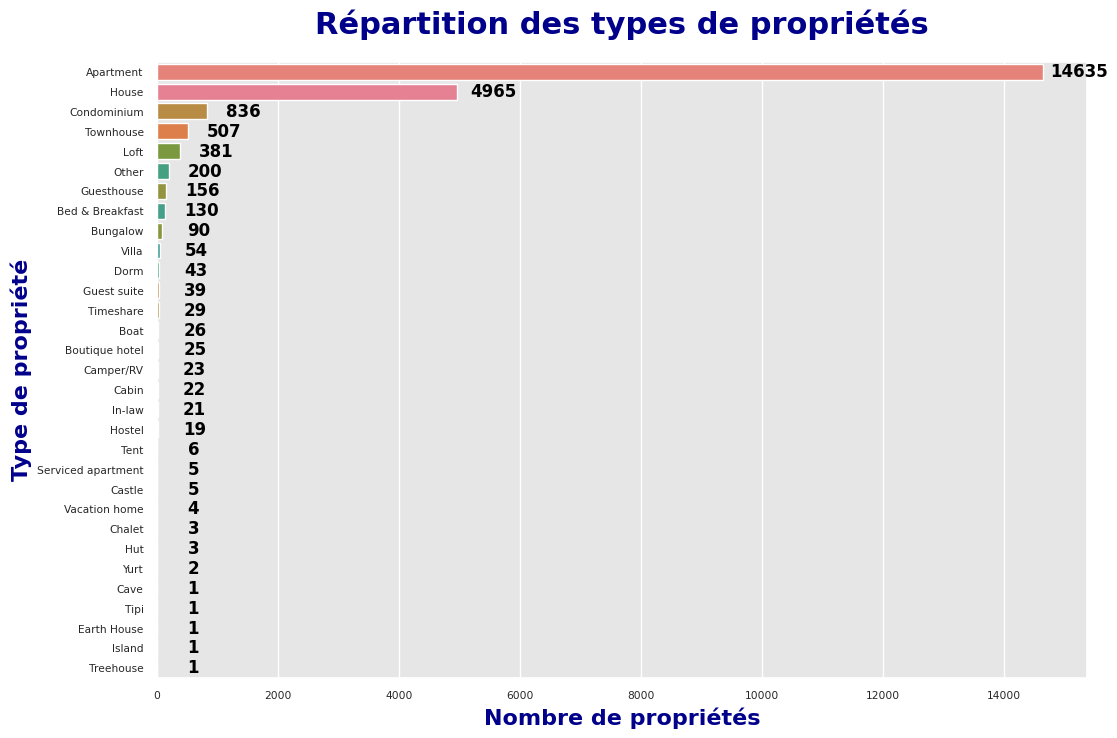

In [19]:
countplot_generator(data, 'property_type','Répartition des types de propriétés', 'Nombre de propriétés', 'Type de propriété')
plt.show()

On remarque ici très clairement que nous allons pouvoir regrouper certains types de propriétés afin de garder des catégories contenant un nombre significatif d'item. Par exemple, il existe déja la catégorie "Other", nous pourrions regrouper l'ensemble des catégories contenant un nombre d'individus inférieurs à celui de "Other" dans cette même catégorie.


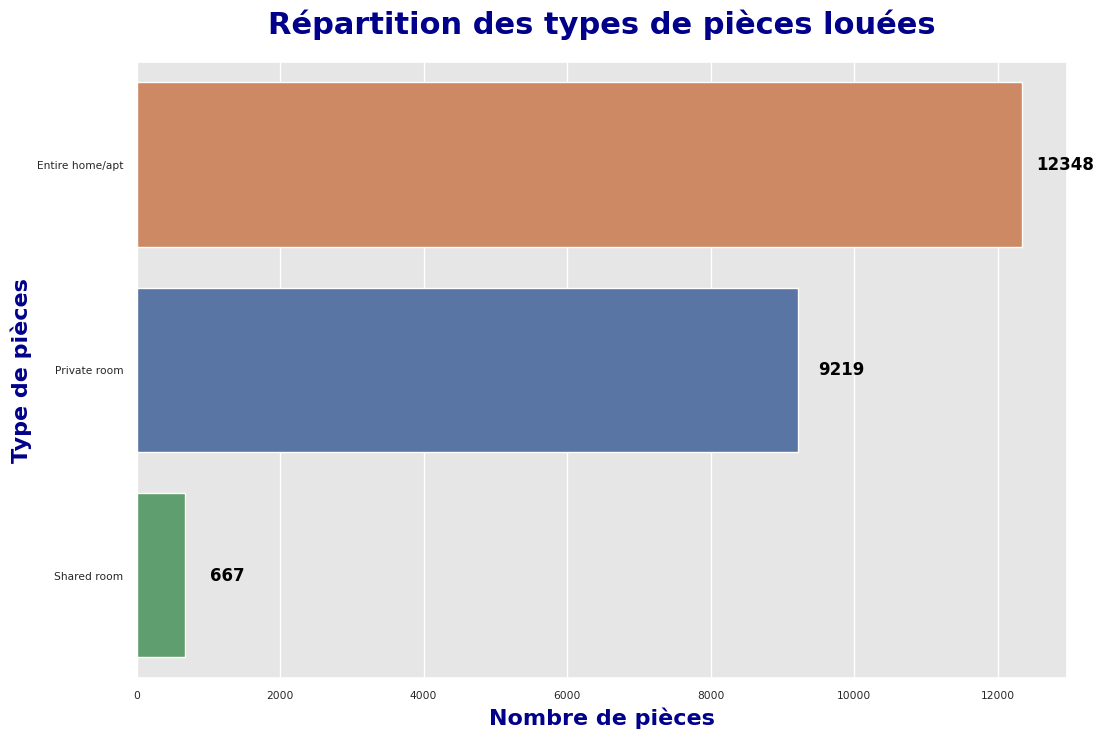

In [20]:
countplot_generator(data, 'room_type', 'Répartition des types de pièces louées', 'Nombre de pièces', 'Type de pièces')

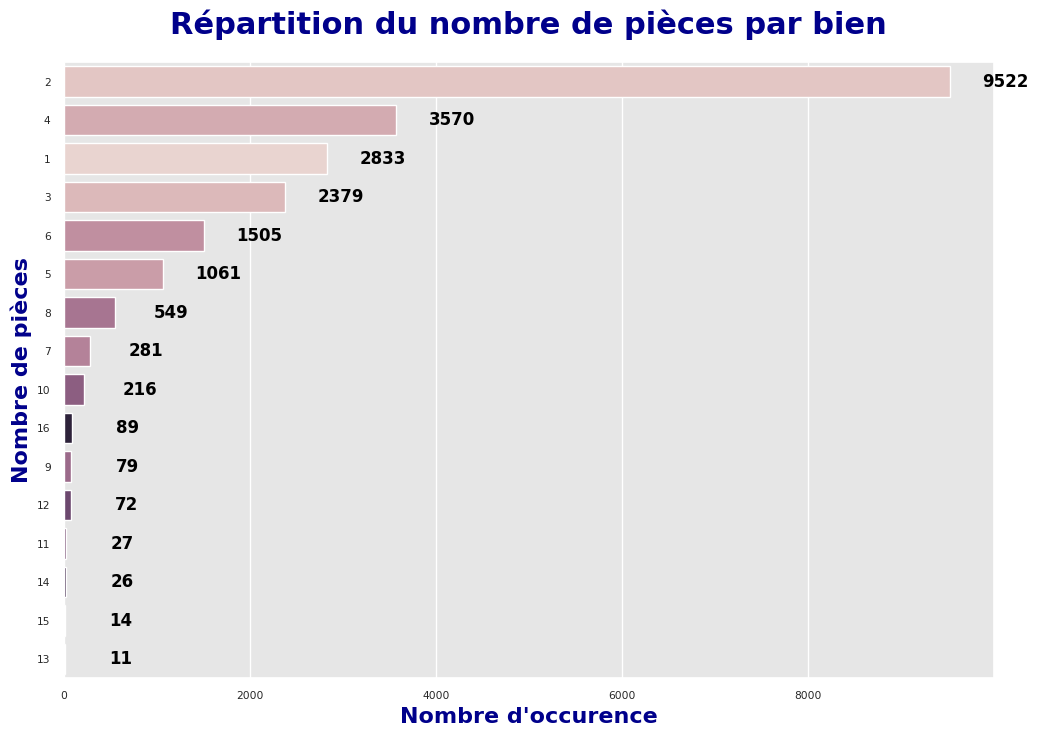

In [21]:
#Trions les étiquettes par ordre croissant
countplot_generator(data, 'accommodates', 'Répartition du nombre de pièces par bien', "Nombre d'occurence", 'Nombre de pièces')

In [23]:
print("Median du nombre de pièces : ",data["accommodates"].median())

Median du nombre de pièces :  2.0


Il est curieux de voir que certains logements ont un nombre décimal de salle de bain. To be continued ...

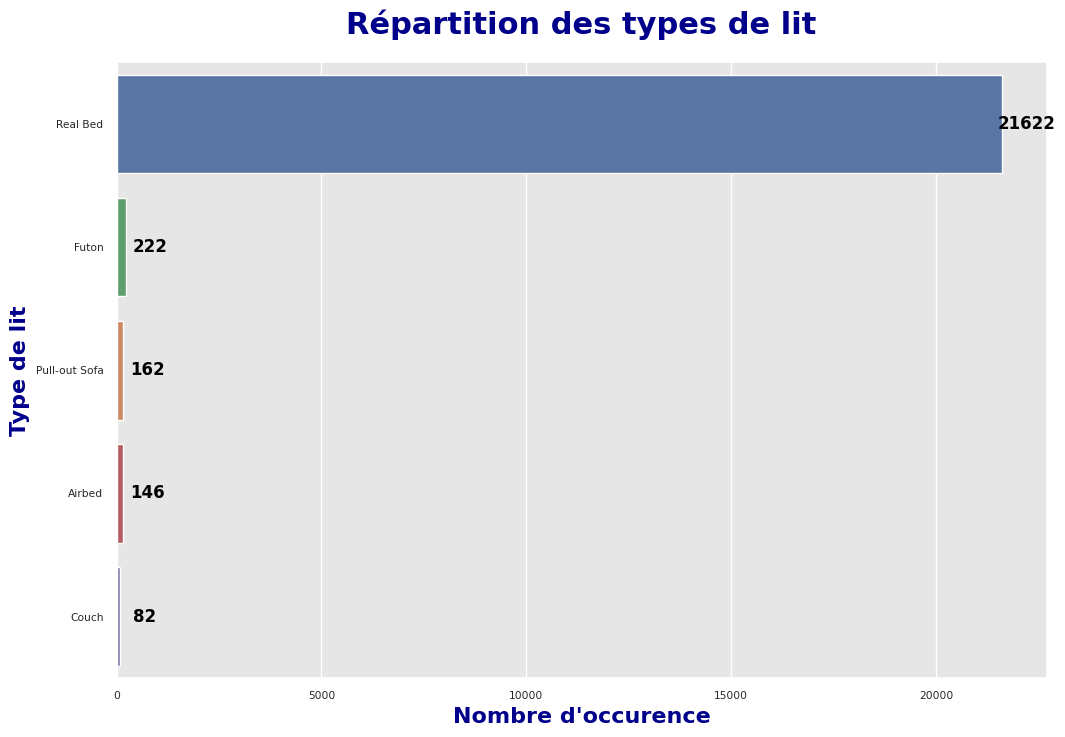

In [24]:
countplot_generator(data, 'bed_type', 'Répartition des types de lit', "Nombre d'occurence", 'Type de lit')

De la même manière que pour les types de propriétés, il peut être intéressant de réduire la dimensionnalité en regroupant certains types de lit dans un catégorie "Others" : Couch, Airbed, Pull-out sofa, Futon.

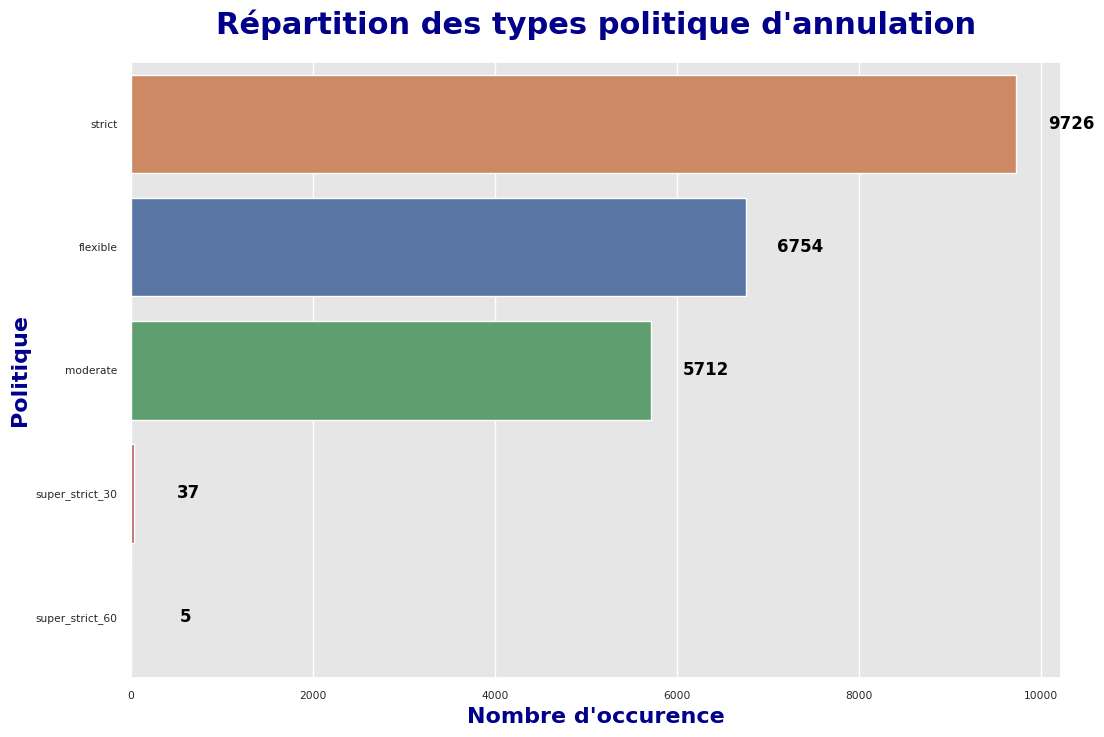

In [25]:
countplot_generator(data, 'cancellation_policy', "Répartition des types politique d'annulation", "Nombre d'occurence", 'Politique')

Les politiques "super_strict_30" et "super_strict_60" sont très peu utilisée par les loueurs de Airbnb. Il ne semble donc pas absolument nécessaire de les garder dans notre étude. Nous supprimons les lignes qui comportent ces politiques d'annulation.

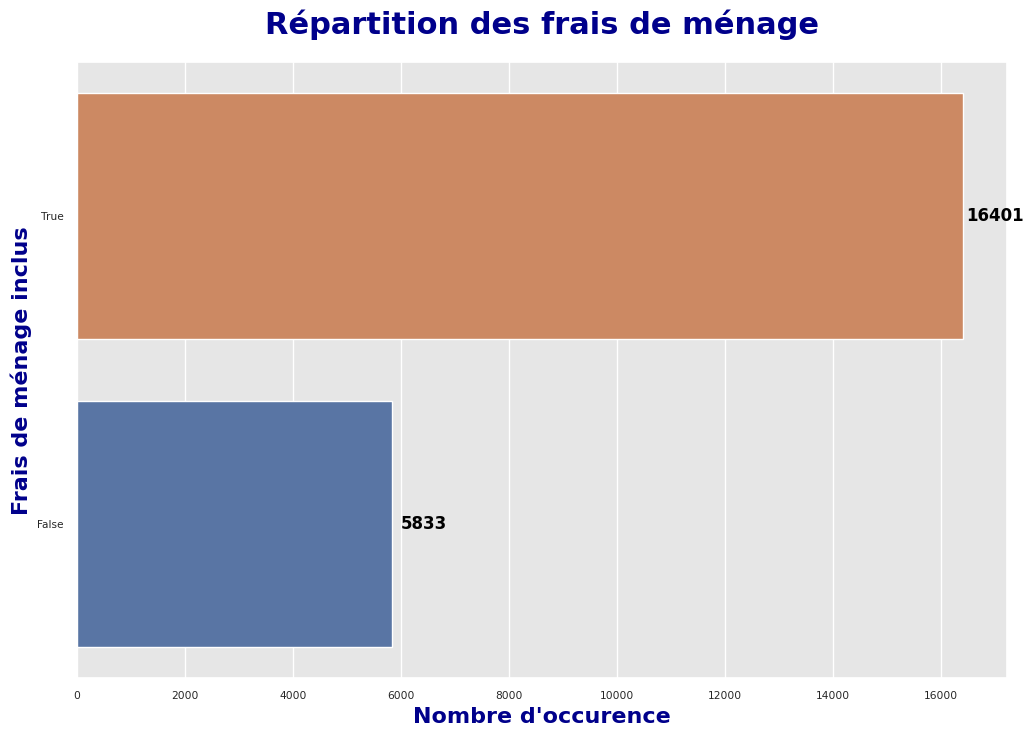

In [26]:
countplot_generator(data, 'cleaning_fee', "Répartition des frais de ménage", "Nombre d'occurence", 'Frais de ménage inclus')

Vérifions que cette colonne est bien composée de boolean : 

In [27]:
print("Type des valeurs : ",data['cleaning_fee'].unique().dtype)

Type des valeurs :  bool


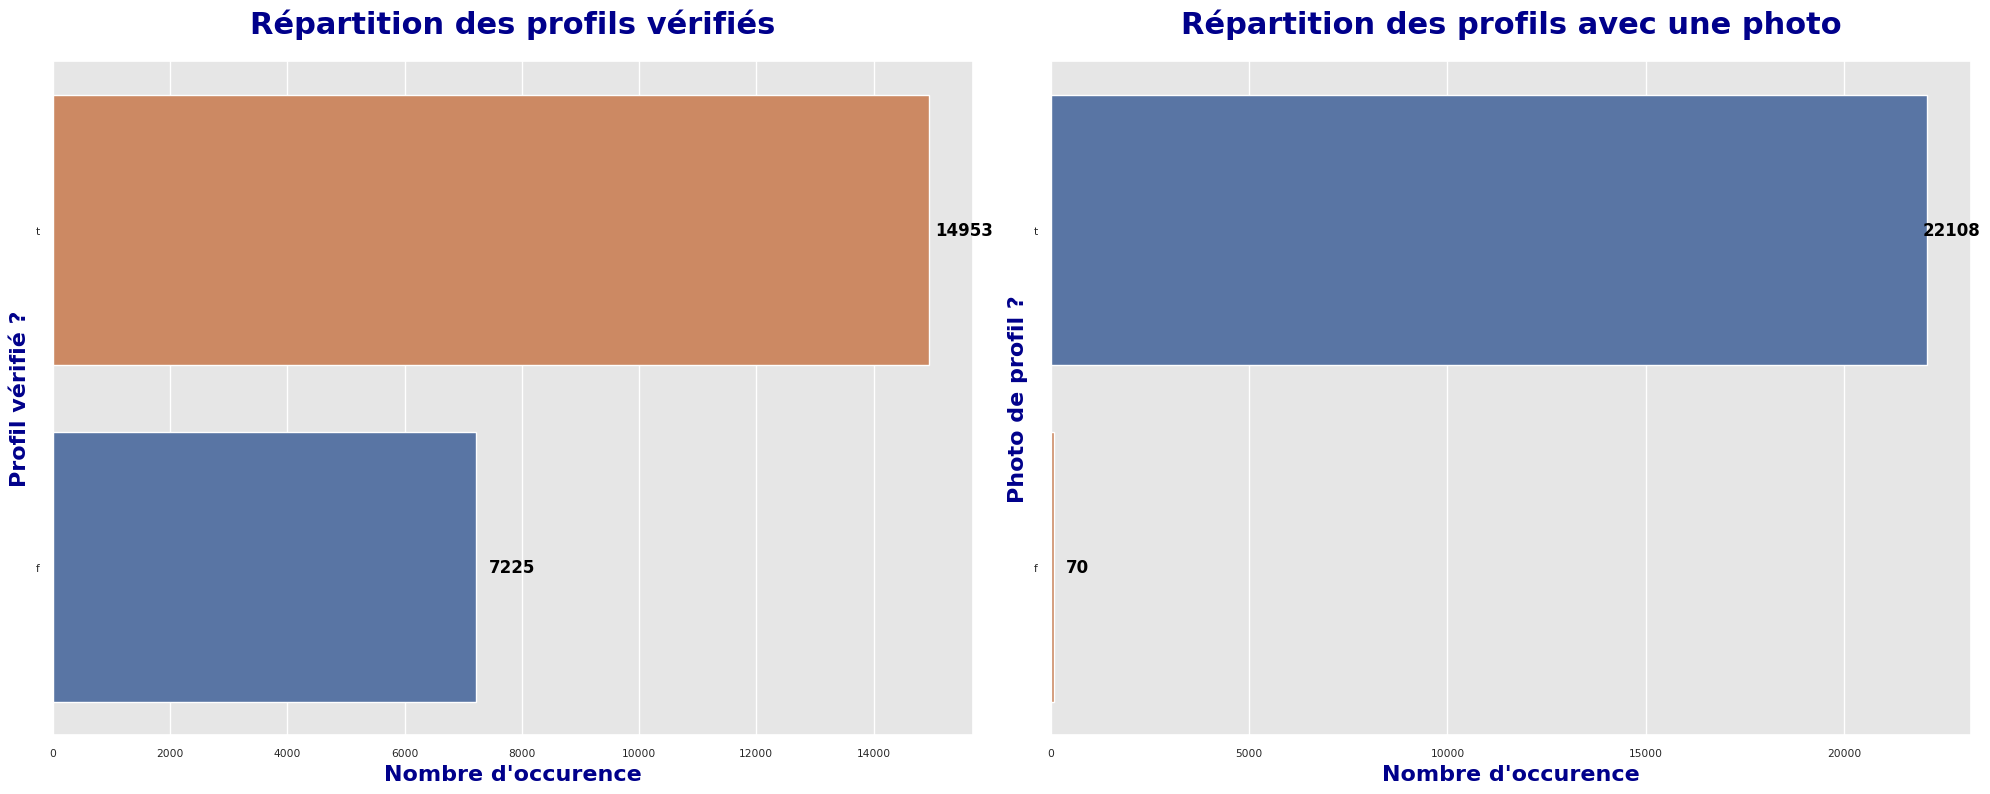

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
countplot_generator(data, 'host_identity_verified', "Répartition des profils vérifiés", "Nombre d'occurence", 'Profil vérifié ?', ax=axes[0])
countplot_generator(data, 'host_has_profile_pic', "Répartition des profils avec une photo", "Nombre d'occurence", 'Photo de profil ?', ax=axes[1])

plt.tight_layout()
plt.show()

##### Photo de profil

In [29]:
data['host_has_profile_pic'].value_counts(normalize=True)

host_has_profile_pic
t    0.996844
f    0.003156
Name: proportion, dtype: float64

In [30]:
print("Type des valeurs : ",data['host_has_profile_pic'].unique().dtype)

Type des valeurs :  object


Les profils ayant une photo de profile représente plus de 99% du dataset, nous supprimerons les 70 lignes correspondants à ceux qui n'en ont pas. De plus, les valeurs sont de type "string", nous veillerons à les convertir en boolean : t = True et f = False.

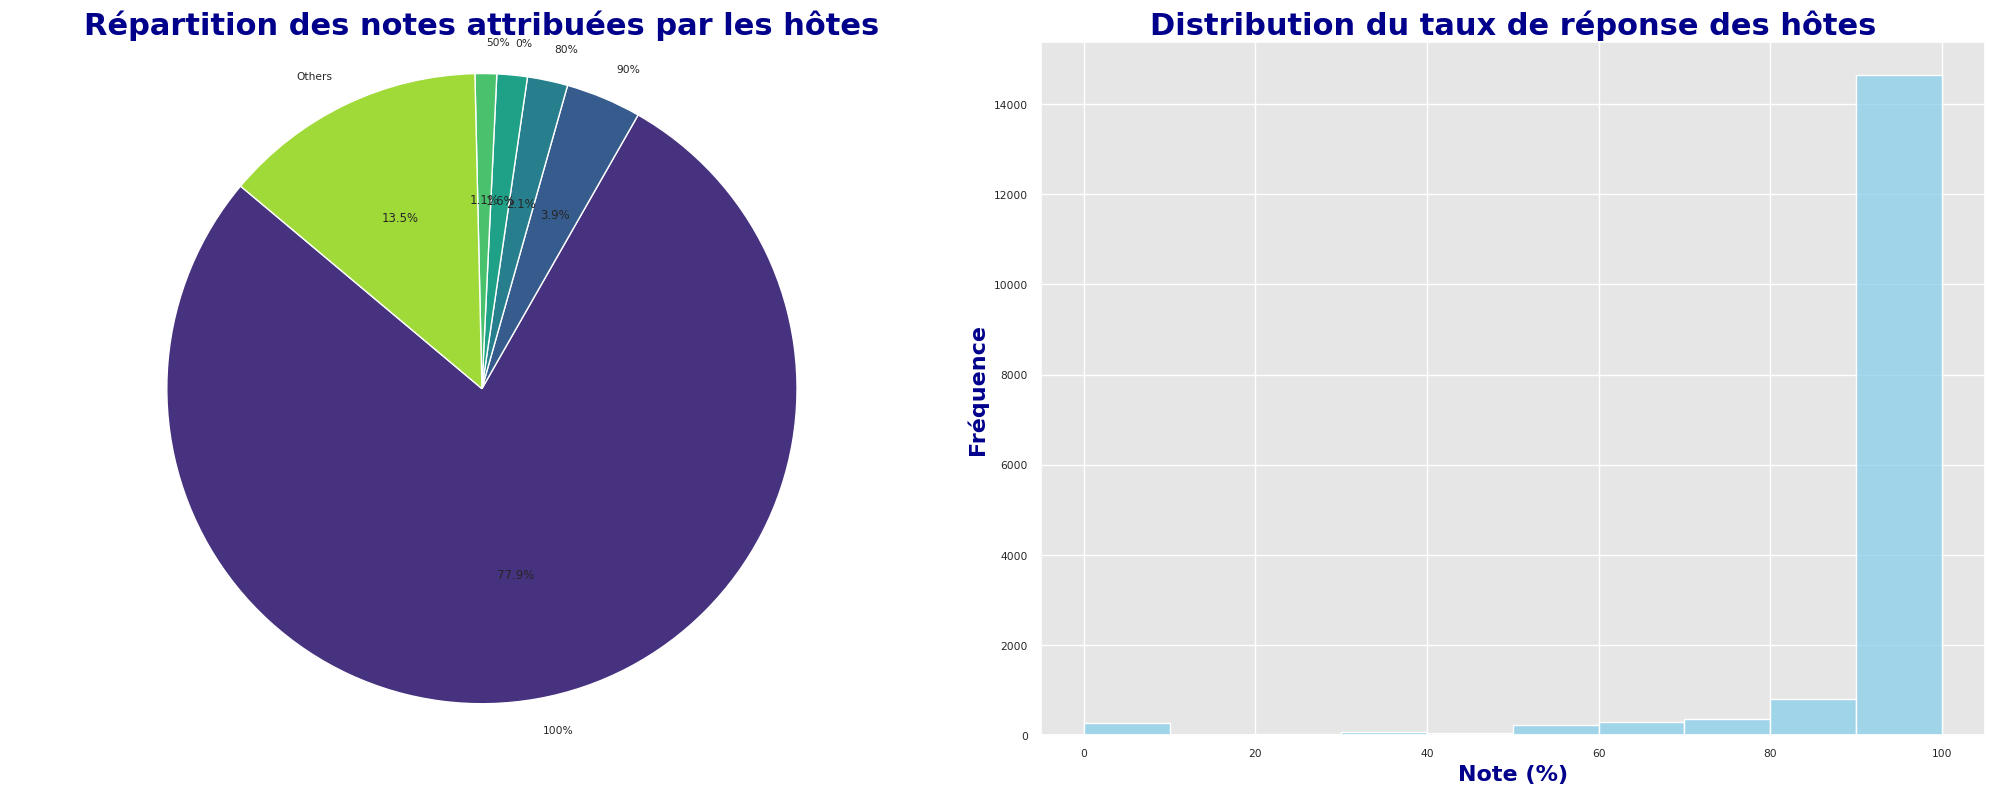

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
piechart_generator(data, 'host_response_rate', threshold=0.01, title='Répartition des notes attribuées par les hôtes', ax=axes[0])
data_bis = pd.read_csv('./data/airbnb_train.csv')

data_bis['host_response_rate'] = data_bis['host_response_rate'].str.rstrip('%')  # Supprimer le caractère '%'
data_bis['host_response_rate'] = pd.to_numeric(data_bis['host_response_rate'], errors='coerce')  # Convertir en numérique

data_bis = data_bis.dropna(subset=['host_response_rate'])

hist = sns.histplot(data=data_bis, x='host_response_rate', bins=10, kde=False, color='skyblue')


axes[1].set_title('Distribution du taux de réponse des hôtes', fontsize=22, weight='bold', color='darkblue')
axes[1].set_xlabel('Note (%)', fontsize=16, weight='bold', color='darkblue')
axes[1].set_ylabel('Fréquence', fontsize=16, weight='bold', color='darkblue')

plt.tight_layout()
plt.show()



Comme précédemment, nous pouvons peut être regrouper certaines valeurs dans des catégorie définies. A première vue, nous pourrions regrouper : 90-100% | 70-90% | ...

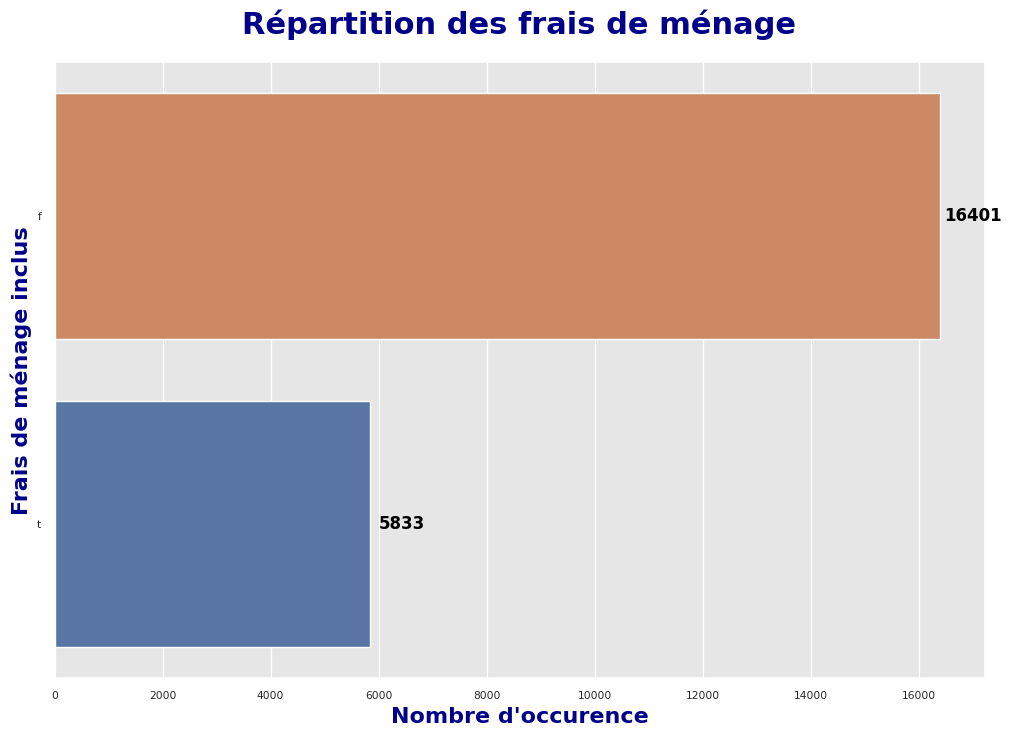

In [32]:
countplot_generator(data, 'instant_bookable', "Répartition des frais de ménage", "Nombre d'occurence", 'Frais de ménage inclus')

Encore une fois, il sera nécessaire de modifier le type des données afin de bien avoir des boolean.

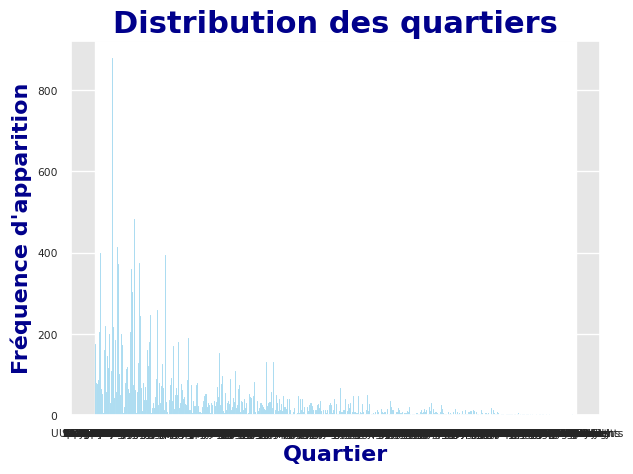

In [33]:
data_bis = pd.read_csv('./data/airbnb_train.csv')

hist = sns.histplot(data=data_bis, x='neighbourhood', bins=10, kde=False, color='skyblue')


plt.title('Distribution des quartiers', fontsize=22, weight='bold', color='darkblue')
plt.xlabel('Quartier', fontsize=16, weight='bold', color='darkblue')
plt.ylabel("Fréquence d'apparition", fontsize=16, weight='bold', color='darkblue')

plt.tight_layout()
plt.show()

Les location sont étalées dans de nopmbreux quartier. Il sera intéréssant de transformer ce type de variables en étiquettes, utilisables pour les algorithme de machine learning.

In [34]:
data.groupby('neighbourhood')['log_price'].mean().sort_values(ascending=False)


neighbourhood
Bellevue         7.408531
Bradbury         7.090077
Huguenot         6.551080
Palos Verdes     6.190013
Spring Valley    6.109248
                   ...   
Hermosa          3.401197
Deanwood         3.345421
South Chicago    3.224805
College Point    3.178054
Twining          3.032897
Name: log_price, Length: 558, dtype: float64

Le quartier Bellevue, s'impose ici comme le plus cher tandis que Twining lui est le moins cher du dataset.

#### Représentation géographique des prix des quartier (sous forme de points chauds)

In [35]:
# Créer une carte centrée sur la moyenne des coordonnées GPS
m = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=4)

#Set data
heat_data = [[row['latitude'], row['longitude'], row['log_price']] for index, row in data.iterrows()]

# Ajouter la heatmap à la carte
HeatMap(heat_data).add_to(m)

# Afficher la carte dans un notebook
m


ModuleNotFoundError: No module named 'folium'

Sous une autre forme :

In [36]:
import pandas as pd
import numpy as np
import plotly.express as px

# Fonction pour créer une carte avec toutes les villes
def create_map_all_cities(data):
    
    data['log_price'] = np.round(data['log_price'], 2)
    
    fig = px.scatter_mapbox(data, 
                            lat="latitude", 
                            lon="longitude", 
                            hover_name="city",
                            hover_data=["log_price"],
                            color='log_price', 
                            zoom=3,
                            color_continuous_scale=px.colors.cyclical.IceFire,
                            title='Prix Airbnb')
    
    fig.update_layout(
        mapbox_style="white-bg",
        mapbox_layers=[{
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": ["https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"]
        }],
        margin={"r":0,"t":0,"l":0,"b":0}
    )
    
    fig.show()
    
create_map_all_cities(data)


ModuleNotFoundError: No module named 'plotly'

Nous nous autorisons à supprimer les lignes où il y a des valeurs non définies sur les colonnes dont le pourcentage de NaN est très faible : <2%


In [17]:
def default_clean(data: pd.Series) -> pd.Series:
# changements des valeurs manquantes dans la colonne review_scores_rating par le dernier quartile
    data["review_scores_rating"] = data["review_scores_rating"].fillna(
        data["review_scores_rating"].quantile(0.25)
    )
    # if host_identity_verified if none then false
    data["host_identity_verified"] = data["host_identity_verified"].fillna("f")


    # fill host_response_rate with quantile 0.75
    def getSTRQuantile75(column) -> float:
        # parse "%" to float and divide by 100 ignoring nan
        column = column.str.replace("%", "").astype(float)
        return column.quantile(0.10)


    def getFloatQuantile75(column) -> float:
        return column.quantile(0.10)


    my_quantil = getSTRQuantile75(data["host_response_rate"])
    # remove % from column
    data["host_response_rate"] = data["host_response_rate"].str.replace("%", "")
    data["host_response_rate"] = data["host_response_rate"].fillna(my_quantil)
    data["host_response_rate"] = data["host_response_rate"].astype(float)

    bedQuantil = getFloatQuantile75(data["beds"])
    data["beds"] = data["beds"].fillna(bedQuantil)

    bathQuantil = getFloatQuantile75(data["bathrooms"])
    data["bathrooms"] = data["bathrooms"].fillna(bathQuantil)

    # in column instant_bookable replace t by True and f by False
    data["instant_bookable"] = data["instant_bookable"].replace({"t": True, "f": False})
    data["host_identity_verified"] = data["host_identity_verified"].replace({"t": True, "f": False})

    # Suppression des colonnes inutiles
    data = data.drop(
        columns=[
            "id",
            "name",
            "last_review",
            "first_review",
            "zipcode",
            "host_has_profile_pic",
            "host_since",
            "bedrooms",
            "description"
        ]
    )

    return data
data = default_clean(data)
data_test = default_clean(data_test)

/tmp/ipykernel_255757/4225775076.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["instant_bookable"] = data["instant_bookable"].replace({"t": True, "f": False})
/tmp/ipykernel_255757/4225775076.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["host_identity_verified"] = data["host_identity_verified"].replace({"t": True, "f": False})


/tmp/ipykernel_255757/4225775076.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["instant_bookable"] = data["instant_bookable"].replace({"t": True, "f": False})
/tmp/ipykernel_255757/4225775076.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["host_identity_verified"] = data["host_identity_verified"].replace({"t": True, "f": False})


KeyError: "['id'] not found in axis"

In [93]:
pd.set_option("display.max_colwidth", 0)
data[
    [
        "property_type",
        "room_type",
        "bed_type",
        "cancellation_policy",
        "cleaning_fee",
        "city",
        "host_identity_verified",
        "host_response_rate",
        "instant_bookable",
        "neighbourhood",
        "host_identity_verified",
    ]
].agg(["unique"]).transpose()

,unique
property_type,"[House, Apartment, Townhouse, Guest suite, Condominium, Timeshare, Chalet, Guesthouse, Bungalow, Loft, In-law, Boat, Dorm, Other, Bed & Breakfast, Camper/RV, Villa, Boutique hotel, Cabin, Hostel, Hut, Yurt, Serviced apartment, Castle, Vacation home, Tent, Cave, Tipi, Earth House, Island, Treehouse]"
room_type,"[Private room, Entire home/apt, Shared room]"
bed_type,"[Real Bed, Pull-out Sofa, Futon, Airbed, Couch]"
cancellation_policy,"[flexible, strict, moderate, super_strict_30, super_strict_60]"
cleaning_fee,"[False, True]"
city,"[LA, NYC, DC, SF, Chicago, Boston]"
host_identity_verified,"[False, True]"
host_response_rate,"[81.0, 100.0, 80.0, 86.0, 90.0, 89.0, 40.0, 70.0, 99.0, 0.0, 20.0, 67.0, 56.0, 43.0, 75.0, 94.0, 88.0, 95.0, 60.0, 83.0, 78.0, 96.0, 50.0, 87.0, 97.0, 91.0, 79.0, 98.0, 63.0, 71.0, 93.0, 92.0, 64.0, 42.0, 82.0, 25.0, 33.0, 54.0, 73.0, 57.0, 58.0, 17.0, 30.0, 85.0, 53.0, 44.0, 31.0, 77.0, 29.0, 84.0, 69.0, 68.0, 38.0, 35.0, 52.0, 76.0, 72.0, 14.0, 65.0, 55.0, 74.0, 62.0, 21.0, 47.0, 61.0, 13.0, 46.0, 66.0, 10.0, 26.0]"
instant_bookable,"[True, False]"
neighbourhood,"[Long Beach, Ridgewood, U Street Corridor, Sunnyside, Noe Valley, West Village, Harlem, Flushing, Westside, Upper West Side, Shepherd Park, Santa Monica, Mission District, Murray Hill, nan, Chinatown, Echo Park, Hamilton Heights, Mar Vista, Encino, Kips Bay, Williamsburg, West Hollywood, Carroll Gardens, Downtown, Bedford-Stuyvesant, Wicker Park, Hell's Kitchen, Upper East Side, Pasadena, Shaw, Greenpoint, Jackson Heights, Clinton Hill, Tompkinsville, Torrance, Beverly Hills, Midtown, Financial District, Fort Greene, Pacific Heights, Mid-City, Chelsea, Venice, Crown Heights, South LA, Bushwick, Parkchester, Glendale, Columbia Street Waterfront, East Flatbush, Western Addition/NOPA, Hollywood, East Village, Lower East Side, Nolita, East Elmhurst, Soho, The Rockaways, Beacon Hill, Forest Hills, Chevy Chase, Flatbush, Lefferts Garden, Park Slope, East Harlem, Compton, Glover Park, Cahuenga Pass, East Hollywood, Trinidad, Elmhurst, Westwood, Astoria, Southwest Waterfront, Near Northeast/H Street Corridor, Mount Vernon Square, Downtown/Penn Quarter, Back Bay, Silver Lake, Nob Hill, Whittier, Mid-Wilshire, Richmond District, Inglewood, Granada Hills North, Coney Island, Russian Hill, Westlake, Jamaica Plain, Ditmars / Steinway, Midtown East, Capitol Hill, Monterey Park, East Boston, Westchester/Playa Del Rey, Sunset Park, Alphabet City, Mattapan, Cole Valley, ...]"


## Comptons quel est la representation de chaque type de logement:


Notre analyse ne nécessitera pas les colonnes suivantes :

- id : notre dataframe associe déjà des id à chaque ligne.
- city / latitude et longitude : Nous utiliserons les zipcode analyser par zone géographique.
- first review / last rewiew : Difficile à exploiter.
- name : Semble inutile ici.


In [94]:
def extract_dict_amneties(amenities_str: str) -> list:
    # Remove curly braces and split by comma
    amenities: re = re.findall(r'"(.*?)"|(\b\w+\b)', amenities_str)
    # Flatten the list and remove empty strings
    return [item for sublist in amenities for item in sublist if item]


def getUsefullAmneties(data: pd.Series) -> pd.Series:
    # Extract and treat all amenities
    all_amenities: pd.Series = data["amenities"].apply(extract_dict_amneties)
    # create a dataframe and count everytime an amenity is present
    amenities_df: pd.Series = (
        pd.DataFrame(all_amenities.tolist()).stack().value_counts()
    )
    # remove when it is lower than 0.5% of the biggest value
    return amenities_df[amenities_df >= amenities_df.max() * 0.01]


to_keep = getUsefullAmneties(data)

In [95]:
def extract_amenities(data: pd.Series, amnetiesToKeep: pd.Series) -> pd.Series:
    all_amenities: pd.Series = data["amenities"].apply(extract_dict_amneties)
    amenities_list: pd.Series = amnetiesToKeep.index.tolist()

    # Logs the number of amenities removed
    logging.info(
        "We have removed a total of",
        len(amnetiesToKeep) - len(all_amenities),
        "amenities",
    )
    logging.info(amnetiesToKeep)

    # Create empty DataFrame with columns for each amenity
    new_columns = {col: np.zeros(len(data), dtype=bool) for col in amenities_list}
    # join and if columns already exists threw an error
    if set(new_columns.keys()).intersection(data.columns):
        raise ValueError("Some columns already exists in the dataframe")
    data = data.join(pd.DataFrame(new_columns))

    # Set values in new columns based on presence of amenities in 'amenities' column
    for amenity in amenities_list:
        mask = data["amenities"].str.contains(amenity)
        # check if it exists a column with the same name
        data[amenity][mask] = True
    # remove the amenities column
    data = data.drop(columns=["amenities"])
    return data


data = extract_amenities(data, to_keep)
data_test = extract_amenities(data_test, to_keep)

/tmp/ipykernel_904031/123537019.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data[amenity][mask] = True
/tmp/ipykernel_904031/123537019.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [96]:
data.property_type.value_counts()

property_type
Apartment             14635
House                 4965 
Condominium           836  
Townhouse             507  
Loft                  381  
Other                 200  
Guesthouse            156  
Bed & Breakfast       130  
Bungalow              90   
Villa                 54   
Dorm                  43   
Guest suite           39   
Timeshare             29   
Boat                  26   
Boutique hotel        25   
Camper/RV             23   
Cabin                 22   
In-law                21   
Hostel                19   
Tent                  6    
Serviced apartment    5    
Castle                5    
Vacation home         4    
Chalet                3    
Hut                   3    
Yurt                  2    
Cave                  1    
Tipi                  1    
Earth House           1    
Island                1    
Treehouse             1    
Name: count, dtype: int64

In [97]:
list(data.property_type.value_counts()[data.property_type.value_counts() <= 300].index)

['Other',
 'Guesthouse',
 'Bed & Breakfast',
 'Bungalow',
 'Villa',
 'Dorm',
 'Guest suite',
 'Timeshare',
 'Boat',
 'Boutique hotel',
 'Camper/RV',
 'Cabin',
 'In-law',
 'Hostel',
 'Tent',
 'Serviced apartment',
 'Castle',
 'Vacation home',
 'Chalet',
 'Hut',
 'Yurt',
 'Cave',
 'Tipi',
 'Earth House',
 'Island',
 'Treehouse']

In [98]:
def CategoryCreation(
    data: pd.DataFrame, column: str, percent: float = 0.01
) -> pd.DataFrame:
    # create a dataframe with the count of each property type
    property_type_count = data[column].value_counts()
    # if it is less than 1% of the biggest group up in other
    data[column] = data[column].apply(
        lambda x: x
        if property_type_count[x] > property_type_count.max() * percent
        else "Other"
    )
    # data = pd.concat([data, pd.get_dummies(data[column], prefix=column)], axis=1)
    # data.drop(columns=[column], axis=1, inplace=True)
    return data


CategoryCreation(data, "property_type")
CategoryCreation(data, "bed_type")
CategoryCreation(data, "cancellation_policy")

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_identity_verified,...,Room-darkening shades,Patio or balcony,Garden or backyard,Host greets you,Children’s books and toys,Pack ’n Play/travel crib,Wide doorway,Well-lit path to entrance,Smartlock,Ethernet connection
0,4.317488,House,Private room,3,1.0,Real Bed,flexible,False,LA,False,...,False,False,False,False,False,False,False,False,False,False
1,4.007333,House,Private room,4,2.0,Real Bed,strict,False,NYC,True,...,False,False,False,False,False,False,False,False,False,False
2,7.090077,Apartment,Entire home/apt,6,2.0,Real Bed,flexible,False,DC,False,...,False,False,False,False,False,False,False,False,False,False
3,3.555348,House,Private room,1,1.0,Real Bed,flexible,True,NYC,True,...,False,False,True,False,False,False,False,False,False,False
4,5.480639,House,Entire home/apt,4,1.0,Real Bed,moderate,True,SF,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22229,4.605170,Apartment,Private room,1,1.0,Real Bed,flexible,False,NYC,True,...,False,False,False,False,False,False,False,False,False,False
22230,5.043425,Apartment,Entire home/apt,4,2.0,Real Bed,moderate,True,LA,False,...,False,False,False,False,False,False,False,False,False,False
22231,5.220356,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,True,...,False,False,False,False,False,False,False,False,False,False
22232,5.273000,Apartment,Entire home/apt,2,1.0,Real Bed,strict,True,NYC,False,...,False,False,False,False,False,False,False,False,False,False


In [99]:
def GetMediumPricePerNeighbourhood(data: pd.DataFrame) -> pd.DataFrame:
    return (
        data[["neighbourhood", "log_price"]]
        .groupby("neighbourhood")["log_price"]
        .mean()
        .sort_values(ascending=False)
    )

In [100]:
def GetLocalisationCenterOfNeighbourhood(data: pd.DataFrame) -> pd.DataFrame:
    return (
        data[["neighbourhood", "longitude", "latitude"]].groupby("neighbourhood").mean()
    )


def GetNeighberhoodFromLocalisation(
    longitude: float,
    latitude: float,
    centerCity: pd.DataFrame,
):
    # calculate the distance between the point and the center of the city
    distance = np.sqrt(
        (centerCity["longitude"] - longitude) ** 2
        + (centerCity["latitude"] - latitude) ** 2
    )
    # return the closest neighbourhood
    return distance.idxmin()


# get distance to center of the neighbourhood
def GetDistanceToCenterOfneighberhood(
    centerOfCity: pd.DataFrame,
    longitude: float,
    latitude: float,
    neighbourhood: str,
) -> (float, float):
    # get the center of the neighbourhood
    center = centerOfCity.loc[neighbourhood]
    # calculate the distance between the point and the center of the city
    distance = np.sqrt(
        (center["longitude"] - longitude) ** 2 + (center["latitude"] - latitude) ** 2
    )
    return distance

In [101]:
centerNeighbourhood = GetLocalisationCenterOfNeighbourhood(data)

# for all missing neighbourhood fill with the closest neighbourhood
data["neighbourhood"] = data.apply(
    lambda x: GetNeighberhoodFromLocalisation(
        x["longitude"], x["latitude"], centerNeighbourhood
    )
    if pd.isnull(x["neighbourhood"])
    else x["neighbourhood"],
    axis=1,
)
# missingNeighbourhood = data2[data2["neighbourhood"].isnull()]

In [102]:
# create a column distance to center of the neighbourhood
data["distance_to_center"] = data.apply(
    lambda x: GetDistanceToCenterOfneighberhood(
        centerNeighbourhood, x["longitude"], x["latitude"], x["neighbourhood"]
    ),
    axis=1,
)
data
# remove column lattitude and longitude
data = data.drop(columns=["latitude", "longitude"])

### PRE PROCESSING

In [103]:
data

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_identity_verified,...,Patio or balcony,Garden or backyard,Host greets you,Children’s books and toys,Pack ’n Play/travel crib,Wide doorway,Well-lit path to entrance,Smartlock,Ethernet connection,distance_to_center
0,4.317488,House,Private room,3,1.0,Real Bed,flexible,False,LA,False,...,False,False,False,False,False,False,False,False,False,0.026300
1,4.007333,House,Private room,4,2.0,Real Bed,strict,False,NYC,True,...,False,False,False,False,False,False,False,False,False,0.003979
2,7.090077,Apartment,Entire home/apt,6,2.0,Real Bed,flexible,False,DC,False,...,False,False,False,False,False,False,False,False,False,0.002446
3,3.555348,House,Private room,1,1.0,Real Bed,flexible,True,NYC,True,...,False,True,False,False,False,False,False,False,False,11.838919
4,5.480639,House,Entire home/apt,4,1.0,Real Bed,moderate,True,SF,True,...,False,False,False,False,False,False,False,False,False,0.004382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22229,4.605170,Apartment,Private room,1,1.0,Real Bed,flexible,False,NYC,True,...,False,False,False,False,False,False,False,False,False,0.012449
22230,5.043425,Apartment,Entire home/apt,4,2.0,Real Bed,moderate,True,LA,False,...,False,False,False,False,False,False,False,False,False,0.006893
22231,5.220356,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,True,...,False,False,False,False,False,False,False,False,False,0.010672
22232,5.273000,Apartment,Entire home/apt,2,1.0,Real Bed,strict,True,NYC,False,...,False,False,False,False,False,False,False,False,False,0.005495


# Property Type


In [104]:
#Séparation des données en features et target
X = data.drop(columns=["log_price"])
y = data["log_price"]

In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22234 entries, 0 to 22233
Data columns (total 90 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   log_price                                   22234 non-null  float64
 1   property_type                               22234 non-null  object 
 2   room_type                                   22234 non-null  object 
 3   accommodates                                22234 non-null  int64  
 4   bathrooms                                   22234 non-null  float64
 5   bed_type                                    22234 non-null  object 
 6   cancellation_policy                         22234 non-null  object 
 7   cleaning_fee                                22234 non-null  bool   
 8   city                                        22234 non-null  object 
 9   host_identity_verified                      22234 non-null  bool   
 10  host_respo

In [111]:
# Encodage des variables catégorielles
X_num = data.select_dtypes(exclude='object')
X_cat = data.select_dtypes(include='object')
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X_cat)
X_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [112]:
categorical_columns = [f'{col}_{cat}' for i, col in enumerate(X_cat.columns) for cat in encoder.categories_[i]]
categorical_columns

['property_type_Apartment',
 'property_type_Condominium',
 'property_type_Guesthouse',
 'property_type_House',
 'property_type_Loft',
 'property_type_Other',
 'property_type_Townhouse',
 'room_type_Entire home/apt',
 'room_type_Private room',
 'room_type_Shared room',
 'bed_type_Futon',
 'bed_type_Other',
 'bed_type_Real Bed',
 'cancellation_policy_Other',
 'cancellation_policy_flexible',
 'cancellation_policy_moderate',
 'cancellation_policy_strict',
 'city_Boston',
 'city_Chicago',
 'city_DC',
 'city_LA',
 'city_NYC',
 'city_SF',
 'neighbourhood_16th Street Heights',
 'neighbourhood_Adams Morgan',
 'neighbourhood_Alamo Square',
 'neighbourhood_Albany Park',
 'neighbourhood_Alhambra',
 'neighbourhood_Allerton',
 'neighbourhood_Allston-Brighton',
 'neighbourhood_Alphabet City',
 'neighbourhood_Altadena',
 'neighbourhood_American University Park',
 'neighbourhood_Anacostia',
 'neighbourhood_Andersonville',
 'neighbourhood_Arboretum',
 'neighbourhood_Arcadia',
 'neighbourhood_Arleta',
 '

In [113]:
one_hot_features = pd.DataFrame(X_encoded, columns=categorical_columns)
one_hot_features

,property_type_Apartment,property_type_Condominium,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,...,neighbourhood_Winnetka,neighbourhood_Winthrop,neighbourhood_Woodhaven,neighbourhood_Woodland,neighbourhood_Woodland Hills/Warner Center,neighbourhood_Woodlawn,neighbourhood_Woodley Park,neighbourhood_Woodridge,neighbourhood_Woodside,neighbourhood_Wrigleyville
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22229,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22230,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22231,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22232,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
X_processed = X_num.join(one_hot_features)
X_processed

,log_price,accommodates,bathrooms,cleaning_fee,host_identity_verified,host_response_rate,instant_bookable,number_of_reviews,review_scores_rating,beds,...,neighbourhood_Winnetka,neighbourhood_Winthrop,neighbourhood_Woodhaven,neighbourhood_Woodland,neighbourhood_Woodland Hills/Warner Center,neighbourhood_Woodlawn,neighbourhood_Woodley Park,neighbourhood_Woodridge,neighbourhood_Woodside,neighbourhood_Wrigleyville
0,4.317488,3,1.0,False,False,81.0,True,0,92.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.007333,4,2.0,False,True,100.0,True,38,86.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.090077,6,2.0,False,False,81.0,True,0,92.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.555348,1,1.0,True,True,100.0,False,19,96.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.480639,4,1.0,True,True,100.0,False,15,96.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22229,4.605170,1,1.0,False,True,81.0,False,0,92.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22230,5.043425,4,2.0,True,False,100.0,False,16,93.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22231,5.220356,5,1.0,True,True,100.0,True,43,94.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22232,5.273000,2,1.0,True,False,100.0,True,0,92.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)
X_scaled

array([[-0.64834495, -0.07256784, -0.40209595, ..., -0.01774633,
        -0.03613879, -0.03217954],
       [-1.0798696 ,  0.39388876,  1.30535276, ..., -0.01774633,
        -0.03613879, -0.03217954],
       [ 3.20921227,  1.32680196,  1.30535276, ..., -0.01774633,
        -0.03613879, -0.03217954],
       ...,
       [ 0.60783265,  0.86034536, -0.40209595, ..., -0.01774633,
        -0.03613879, -0.03217954],
       [ 0.68107692, -0.53902444, -0.40209595, ..., -0.01774633,
        -0.03613879, -0.03217954],
       [ 0.09537406,  0.39388876, -0.40209595, ..., -0.01774633,
        -0.03613879, -0.03217954]])

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

In [149]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR()
}

results = {}

for model_name, model in models.items():
    model.fit(X_train[:-20], y_train[:-20])
    y_pred = model.predict(X_test[:-20])
    results[model_name] = mean_squared_error(y_test[:-20], y_pred)

for name, rmse in results.items():
    print(f"{name}: {rmse}")

Linear Regression: 0.00031934354043428915
Random Forest: 4.516840962434184e-06
SVR: 0.06098726592427011


In [150]:
X_predict = X_scaled[-19:]
y_pred12 = models["Linear Regression"].predict(X_predict)
y_pred1 = models["SVR"].predict(X_predict)
y_pred2 = models["Random Forest"].predict(X_predict)

In [151]:
y_pred12

array([4.70048037, 4.94875989, 3.68887945, 4.38202663, 3.91202301,
       4.70048037, 4.55387689, 4.27666612, 4.60517019, 4.58496748,
       4.11087386, 5.13579844, 4.35670883, 4.24849524, 4.60517019,
       5.04342512, 5.22035583, 5.27299956, 4.85203026])

In [152]:
y_pred1

array([4.97178861, 4.93548057, 3.6041338 , 4.31806317, 3.8813675 ,
       4.639774  , 4.51877415, 4.2127514 , 4.54418885, 4.50390864,
       4.21101934, 5.17618746, 4.65066001, 4.14827413, 4.6846885 ,
       5.10161674, 5.28848338, 5.27525619, 4.82131361])

In [153]:
y_pred2

array([4.70048037, 4.94875989, 3.68887945, 4.38202663, 3.91202301,
       4.70048037, 4.55387689, 4.27666612, 4.60517019, 4.58496748,
       4.11087386, 5.13579844, 4.35670883, 4.24849524, 4.60517019,
       5.04342512, 5.22035583, 5.27299956, 4.85203026])

In [154]:
X_processed.tail(20)

,log_price,accommodates,bathrooms,cleaning_fee,host_identity_verified,host_response_rate,instant_bookable,number_of_reviews,review_scores_rating,beds,...,neighbourhood_Winnetka,neighbourhood_Winthrop,neighbourhood_Woodhaven,neighbourhood_Woodland,neighbourhood_Woodland Hills/Warner Center,neighbourhood_Woodlawn,neighbourhood_Woodley Park,neighbourhood_Woodridge,neighbourhood_Woodside,neighbourhood_Wrigleyville
22214,5.010635,2,1.0,False,True,70.0,False,5,100.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22215,4.700480,4,2.0,True,True,90.0,True,15,96.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22216,4.948760,4,1.0,True,True,100.0,False,19,91.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22217,3.688879,2,1.0,True,True,100.0,False,7,86.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22218,4.382027,2,1.0,False,True,81.0,False,0,92.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22219,3.912023,2,1.0,False,False,81.0,False,2,60.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22220,4.700480,2,1.0,True,True,100.0,True,31,92.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22221,4.553877,4,1.0,True,True,100.0,False,177,88.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22222,4.276666,2,1.0,True,True,100.0,True,50,96.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22223,4.605170,2,1.0,True,True,100.0,False,32,93.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
